In [43]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ICT Capstone 2022 
Electricity Demand Forecasting with Machine Learning

@authors: 
Viriya Duch Sam
Su Hyun Kim
Kim Khanh Tran
Paola Abrogueña

PART 3: Feature Selection with Random Forest-Recursive Feature Elimination
Version 1.1.1 (Final)

Objective: 
- Feature Selection
- Impacts of COVID-19 Considerations

"""

'\nICT Capstone 2022 \nElectricity Demand Forecasting with Machine Learning\n\n@authors: \nViriya Duch Sam\nSu Hyun Kim\nKim Khanh Tran\nPaola Abrogueña\n\nPART 3: Feature Selection with Random Forest-Recursive Feature Elimination\nVersion 1.1.1 (Final)\n\nObjective: \n- Feature Selection\n- Impacts of COVID-19 Considerations\n\n'

In [45]:
import os

## Data manipulation
import numpy as np
import pandas as pd 
from datetime import datetime
from operator import itemgetter

## Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Features Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

## Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import pickle

In [4]:
sns.set_style('whitegrid')

In [5]:
# Import clean dataset
fname = "engineered_data.csv"

df = pd.read_csv(fname)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   demand                  2106 non-null   float64
 1   min_temperature         2106 non-null   float64
 2   max_temperature         2106 non-null   float64
 3   solar_exposure          2106 non-null   float64
 4   rainfall                2106 non-null   float64
 5   school_day              2106 non-null   int64  
 6   holiday                 2106 non-null   int64  
 7   month                   2106 non-null   int64  
 8   season                  2106 non-null   int64  
 9   day_of_week             2106 non-null   int64  
 10  weekend                 2106 non-null   int64  
 11  pre_covid               2106 non-null   int64  
 12  demand_7_days_lag       2106 non-null   float64
 13  demand_14_days_lag      2106 non-null   float64
 14  demand_28_days_lag    

# Feature Selection
We will examine different algorithms for feature selection.

## Pearson's correlation coefficient
Generating a corr matrix and heatmap to give us an overview of the overall features correlation in our dataset. 

In [7]:
df.corr(method='pearson').fillna(0)

,demand,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,month,season,day_of_week,...,rainfall_28_mean,rainfall_7_std,rainfall_14_std,rainfall_28_std,rainfall_7_min,rainfall_14_min,rainfall_28_min,rainfall_7_max,rainfall_14_max,rainfall_28_max
demand,1.000000,-0.156118,-0.073216,-0.257471,-0.064662,0.123030,-0.247683,-0.064497,0.055263,-0.380876,...,-0.081587,-0.100104,-0.124710,-0.159175,0.029533,0.0,0.0,-0.097276,-0.127115,-0.162100
min_temperature,-0.156118,1.000000,0.705433,0.376205,-0.002938,-0.082904,0.066620,-0.297397,-0.516048,0.009727,...,-0.038426,0.002572,0.096944,0.154884,-0.046263,0.0,0.0,0.001768,0.116338,0.197947
max_temperature,-0.073216,0.705433,1.000000,0.598929,-0.154980,-0.092532,0.042487,-0.203343,-0.425016,-0.005954,...,-0.092177,-0.048293,0.032906,0.097136,-0.052583,0.0,0.0,-0.047439,0.053516,0.144489
solar_exposure,-0.257471,0.376205,0.598929,1.000000,-0.123249,-0.095344,0.045196,0.038285,-0.266858,-0.011601,...,-0.013251,0.032684,0.095742,0.126527,-0.044524,0.0,0.0,0.035672,0.112894,0.159840
rainfall,-0.064662,-0.002938,-0.154980,-0.123249,1.000000,-0.014316,-0.014925,0.019875,-0.020129,0.036856,...,0.200880,0.388546,0.249746,0.172505,0.034841,0.0,0.0,0.383843,0.240031,0.149396
school_day,0.123030,-0.082904,-0.092532,-0.095344,-0.014316,1.000000,-0.170251,0.149565,0.151921,-0.020883,...,0.029605,-0.021784,-0.012814,-0.037065,-0.045091,0.0,0.0,-0.022338,-0.018317,-0.069672
holiday,-0.247683,0.066620,0.042487,0.045196,-0.014925,-0.170251,1.000000,-0.056674,-0.086334,-0.065813,...,0.012881,0.055187,0.068458,0.023659,-0.014013,0.0,0.0,0.054435,0.069455,0.020986
month,-0.064497,-0.297397,-0.203343,0.038285,0.019875,0.149565,-0.056674,1.000000,0.608990,0.001798,...,0.077059,0.003174,-0.021010,-0.076078,0.019556,0.0,0.0,0.008489,-0.026675,-0.102416
season,0.055263,-0.516048,-0.425016,-0.266858,-0.020129,0.151921,-0.086334,0.608990,1.000000,-0.002487,...,-0.071920,-0.094664,-0.153931,-0.227008,0.043124,0.0,0.0,-0.091130,-0.158570,-0.241097
day_of_week,-0.380876,0.009727,-0.005954,-0.011601,0.036856,-0.020883,-0.065813,0.001798,-0.002487,1.000000,...,-0.001186,-0.000782,0.000825,0.001012,-0.001044,0.0,0.0,-0.000260,0.001140,0.002078


We see that rainfall_14_min and rainfall_28_min have 0 correlation with every other feature. This is most likely because minimum rainfall would be 0 (i.e., on days without rain). So we decide to remove these 2 columns entirely from our dataset.

In [8]:
## Remove rainfall_14_min and 28
df = df.drop(columns=['rainfall_14_min', 'rainfall_28_min'])

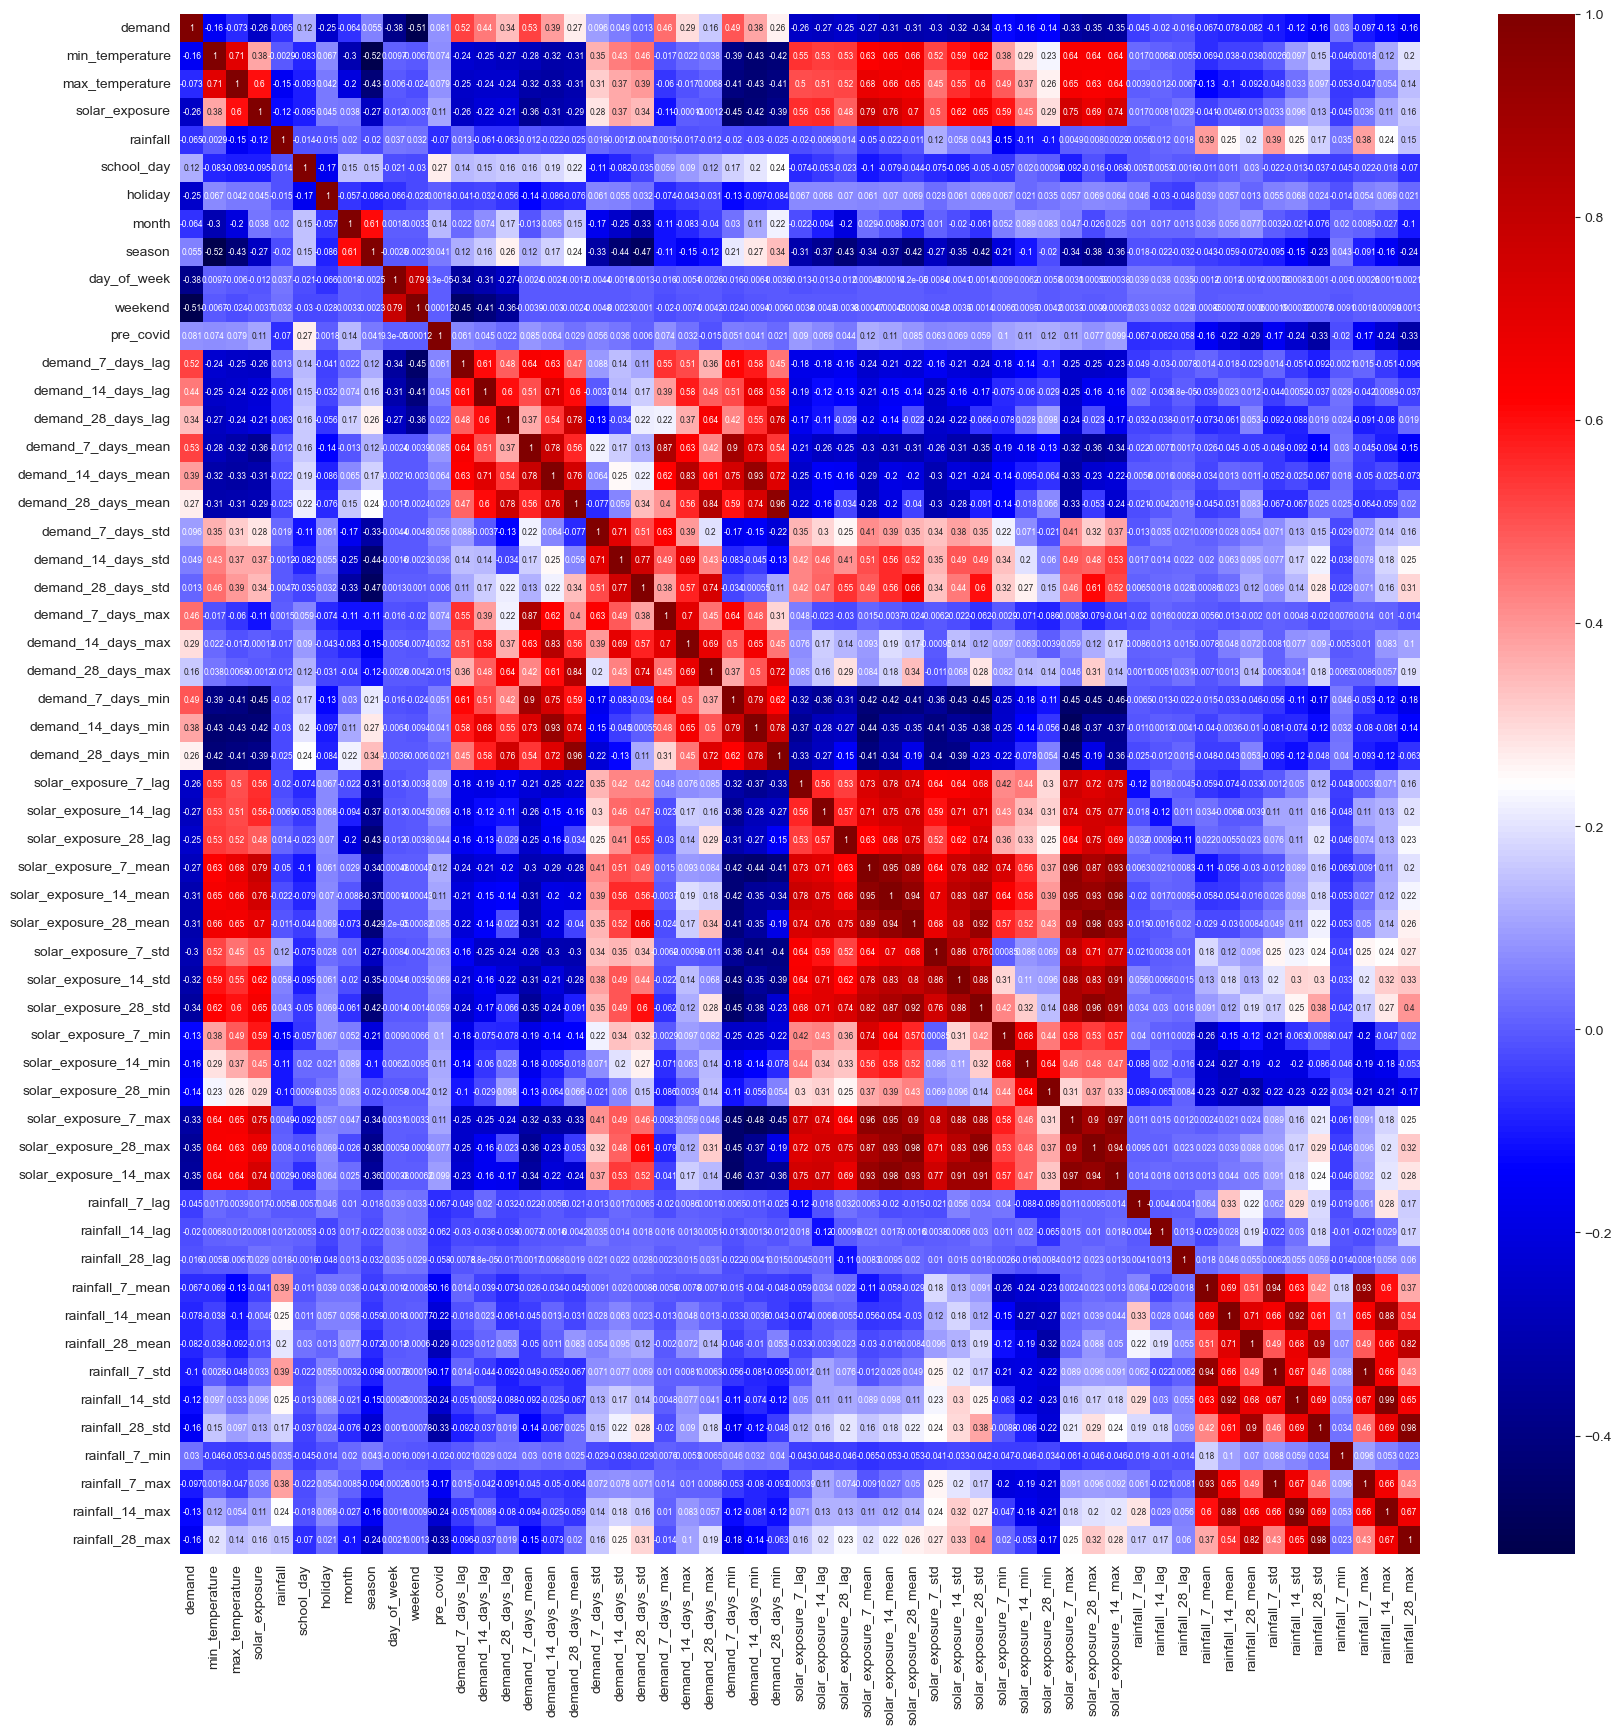

In [11]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(method= 'pearson'), annot=True, cmap="seismic", annot_kws={"size":6})
plt.show()

While a correlation heatmap quickly gives us an impression of the every features correlation, in the case of our very big (57 columns) data set, it is not efficient or feasible for us to manually select the best features by visual perception alone. We will explore a more comprehensive feature selection algorithm below.

## Random Forest - Recursive Features Elimination 
Here, we propose a combined learning algorithm in order to study and select features based on their importance for our regression task. 

### Build a Random Forest Estimator
Random Forest is a very popular, non-computationally-intensive Machine Learning algorithm for both classification and regression problems. A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. In the case of our Electricity Demand Forecasting, which is a time-series problem, we can use an Random Decision Forest Regressor, where we apply a Randomised Search Cross-Validation in order to determine the most optimal parameters for our Random Forest Regressor.

#### Split Train-Test Sets

In [12]:
split = int(len(df) * 0.8)

df_train = df[:split]
df_test = df[split:]

X_train, y_train = (df_train, df_train.demand)
X_test, y_test = (df_test, df_test.demand)

### Find Best Parameters for RF Regressor

In [14]:
# Define the Estimator
estimator = RandomForestRegressor()

# Define Parameter Ranges
number_of_iterations = 30
max_leaf_nodes = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [5, 10, 20, 50]
max_depth = [5,10,15,20,25]
max_features = [3,4,5,6,7,8,9,10]
n_estimators = [100, 200, 250, 300]

# Param Distribution Dictionary
param_distributions = dict(max_leaf_nodes=max_leaf_nodes, 
                           min_samples_split=min_samples_split, 
                           max_depth=max_depth,
                           n_estimators=n_estimators,
                           max_features=max_features)

# Randomised Search Cross-Validation
rscv = RandomizedSearchCV(estimator=estimator, 
                          param_distributions=param_distributions, 
                          n_iter=number_of_iterations, 
                          cv = 5,
                          verbose = 5)

rscv_results = rscv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END max_depth=5, max_features=10, max_leaf_nodes=2, min_samples_split=5, n_estimators=100;, score=0.509 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=10, max_leaf_nodes=2, min_samples_split=5, n_estimators=100;, score=0.447 total time=   0.0s
[CV 3/5] END max_depth=5, max_features=10, max_leaf_nodes=2, min_samples_split=5, n_estimators=100;, score=0.504 total time=   0.0s
[CV 4/5] END max_depth=5, max_features=10, max_leaf_nodes=2, min_samples_split=5, n_estimators=100;, score=0.463 total time=   0.0s
[CV 5/5] END max_depth=5, max_features=10, max_leaf_nodes=2, min_samples_split=5, n_estimators=100;, score=0.427 total time=   0.0s
[CV 1/5] END max_depth=5, max_features=3, max_leaf_nodes=6, min_samples_split=20, n_estimators=100;, score=0.605 total time=   0.0s
[CV 2/5] END max_depth=5, max_features=3, max_leaf_nodes=6, min_samples_split=20, n_estimators=100;, score=0.566 total time=   0.0s
[CV 3/5] END m

In [15]:
# Summarize the results in a readable format
print("Best params:\n {0}, \n\n Using {1}".format(rscv_results.cv_results_['mean_test_score'], rscv_results.best_params_))

Best params:
 [0.47004439 0.5797247  0.48068137 0.70010679 0.73663836 0.70208646
 0.78443074 0.59800449 0.67367709 0.7427856  0.39397466 0.44022038
 0.70170391 0.6050546  0.70669563 0.77945215 0.59382975 0.45544059
 0.61255768 0.58631077 0.55688226 0.67865324 0.8544349  0.64365503
 0.68794409 0.44059773 0.78231261 0.70817953 0.6039315  0.7332001 ], 

 Using {'n_estimators': 250, 'min_samples_split': 10, 'max_leaf_nodes': 10, 'max_features': 10, 'max_depth': 20}


In [16]:
# Print all params results in a dataframe
pd.DataFrame(rscv_results.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.124229,0.001717,0.005705,0.002376,100,5,2,10,5,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.509089,0.446749,0.503827,0.463242,0.427314,0.470044,0.031876,26
1,0.095677,0.004526,0.005098,0.002163,100,20,6,3,5,"{'n_estimators': 100, 'min_samples_split': 20,...",0.605054,0.566216,0.619854,0.595258,0.512242,0.579725,0.038025,23
2,0.095341,0.003158,0.004562,0.002313,100,50,3,4,20,"{'n_estimators': 100, 'min_samples_split': 50,...",0.530727,0.417380,0.546082,0.475932,0.433286,0.480681,0.051103,25
3,0.383493,0.004630,0.013731,0.001774,250,10,4,10,15,"{'n_estimators': 250, 'min_samples_split': 10,...",0.733644,0.703594,0.733792,0.670239,0.659266,0.700107,0.031086,12
4,0.314200,0.005802,0.010541,0.002056,200,50,5,9,25,"{'n_estimators': 200, 'min_samples_split': 50,...",0.769832,0.736705,0.769456,0.712374,0.694825,0.736638,0.030053,6
5,0.293500,0.006534,0.012241,0.002967,250,20,9,4,20,"{'n_estimators': 250, 'min_samples_split': 20,...",0.724654,0.688489,0.735667,0.683079,0.678544,0.702086,0.023398,10
6,0.426043,0.015227,0.013415,0.002887,250,50,8,8,5,"{'n_estimators': 250, 'min_samples_split': 50,...",0.803822,0.781159,0.811032,0.778161,0.747980,0.784431,0.022192,2
7,0.326310,0.004924,0.014794,0.003258,300,50,4,5,10,"{'n_estimators': 300, 'min_samples_split': 50,...",0.620647,0.577728,0.638552,0.605220,0.547876,0.598004,0.032040,20
8,0.128302,0.003478,0.005102,0.002313,100,5,5,6,25,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.696892,0.633713,0.716808,0.669518,0.651456,0.673677,0.030025,15
9,0.136299,0.005536,0.005264,0.004080,100,50,10,5,10,"{'n_estimators': 100, 'min_samples_split': 50,...",0.754192,0.744621,0.793993,0.711179,0.709943,0.742786,0.031091,5


### Recursive Feature Elimination Model (RFE)
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest features until the specified number of features is reached. RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains. In this case, we git the optimised Random Decision Forest Algorithm, where RFE then ranks features by importance, discards the least important features, and re-fits the model. This process is repeated until a specified number of features remains.

#### Determine Feature Ranking by Importance

In [18]:
# Define new RF model with best estimator
rfr = rscv_results.best_estimator_
n_features_to_select = 1 # Finding the most important feature first

# Fit best RF model onto RFE
rfe = RFE(rfr, n_features_to_select = n_features_to_select, verbose = 1)
rfe.fit(X_train, y_train)

Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 fe

RFE(estimator=RandomForestRegressor(max_depth=20, max_features=10,
                                    max_leaf_nodes=10, min_samples_split=10,
                                    n_estimators=250),
    n_features_to_select=1, verbose=1)

In [19]:
# Print Features Ranking and Importance Scores
features = X_train.columns.to_list()
ranks = rfe.ranking_ 

for x, y in (sorted(zip(ranks, features), key = itemgetter(0))):
    print(x, y)   

1 demand
2 demand_7_days_max
3 demand_14_days_max
4 demand_7_days_min
5 demand_7_days_mean
6 demand_14_days_lag
7 demand_7_days_lag
8 weekend
9 day_of_week
10 max_temperature
11 demand_14_days_mean
12 holiday
13 demand_28_days_lag
14 demand_7_days_std
15 min_temperature
16 demand_14_days_min
17 solar_exposure_28_mean
18 solar_exposure_28_std
19 demand_28_days_max
20 solar_exposure_7_mean
21 demand_28_days_mean
22 solar_exposure_7_min
23 solar_exposure_7_std
24 solar_exposure_28_max
25 demand_28_days_min
26 solar_exposure_14_max
27 solar_exposure_14_mean
28 demand_14_days_std
29 solar_exposure_14_std
30 solar_exposure_14_min
31 solar_exposure
32 demand_28_days_std
33 solar_exposure_7_lag
34 solar_exposure_7_max
35 solar_exposure_14_lag
36 rainfall_28_std
37 rainfall_7_max
38 month
39 pre_covid
40 rainfall_28_mean
41 season
42 rainfall_7_std
43 rainfall_14_max
44 rainfall_7_mean
45 solar_exposure_28_lag
46 rainfall_14_mean
47 rainfall_28_max
48 school_day
49 solar_exposure_28_min
50 rain

### Select Top Features
We are selecting only 25% of our total features. 

In [23]:
rfe = RFE(rfr, n_features_to_select = 0.25, verbose = 5)
rfe.fit(X_train, y_train)

Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 fe

RFE(estimator=RandomForestRegressor(max_depth=20, max_features=10,
                                    max_leaf_nodes=10, min_samples_split=10,
                                    n_estimators=250),
    n_features_to_select=0.25, verbose=5)

In [24]:
# Printed selected features from RF-RFE
selected_features = []
for i in rfe.get_support(indices=True):
    print(features[i])
    selected_features.append(features[i])

demand
max_temperature
holiday
day_of_week
weekend
demand_7_days_lag
demand_14_days_lag
demand_7_days_mean
demand_14_days_mean
demand_7_days_max
demand_14_days_max
demand_7_days_min
demand_14_days_min


## Evaluating Optimised Random Forest Model Error Metrics
We could use our optimised Random Forest model for our Electricity Demand Forecasting Time-Series prediction. The performance metrics used are Mean Absolute Error (MAE), Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE).

In [25]:
# Generate df with only columns of important features
X_important_train = rfe.transform(X_train)
X_important_test = rfe.transform(X_test)

### Comparing Accuracy Of Full-Feature Regressor vs Selected-Features Feature Regressor

In [27]:
# RFR for original
rfr = rscv_results.best_estimator_
rfr.fit(X_train, y_train)

# Apply The Full Featured Classifier To The Test Data
y_pred = rfr.predict(X_test)

In [28]:
# Print Error Metrics for Original Set 
print('------------------------------------------------')
print('Error Metrics for Model with ALL Features\n')
# Average actual demand in test set
actual_average = y_test.mean()
print('* Actual Average Demand: '+ str(np.round(actual_average, 2)))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_pred, y_test)
print('* Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_pred, y_test)
print('* Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_pred, y_test)
print('* Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

print('------------------------------------------------')

------------------------------------------------
Error Metrics for Model with ALL Features

* Actual Average Demand: 115981.93
* Mean Absolute Error (MAE): 3632.67
* Mean Squared Error (MSE): 25864729.83
* Median Absolute Percentage Error (MAPE): 3.15 %
------------------------------------------------


### Train A New Random Forest Regressor Using Only Most Important Features

In [29]:
rfr_important = rscv_results.best_estimator_ # Same parameters are original RFR
rfr_important.fit(X_important_train, y_train)

# Predict on important test set
y_important_pred = rfr_important.predict(X_important_test)

In [31]:
# Print Error Metrics for New Important Set
print('------------------------------------------------')
print('Error Metrics for Model with Top 25% Features\n')
# Average actual demand in test set
actual_average = y_test.mean()
print('* Actual Average Demand: '+ str(np.round(actual_average, 2)))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_important_pred, y_test)
print('* Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_important_pred, y_test)
print('* Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_important_pred, y_test)
print('* Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

print('------------------------------------------------')

------------------------------------------------
Error Metrics for Model with Top 25% Features

* Actual Average Demand: 115981.93
* Mean Absolute Error (MAE): 1066.85
* Mean Squared Error (MSE): 2862951.77
* Median Absolute Percentage Error (MAPE): 0.95 %
------------------------------------------------


### Plot Prediction vs Actual for RF Models

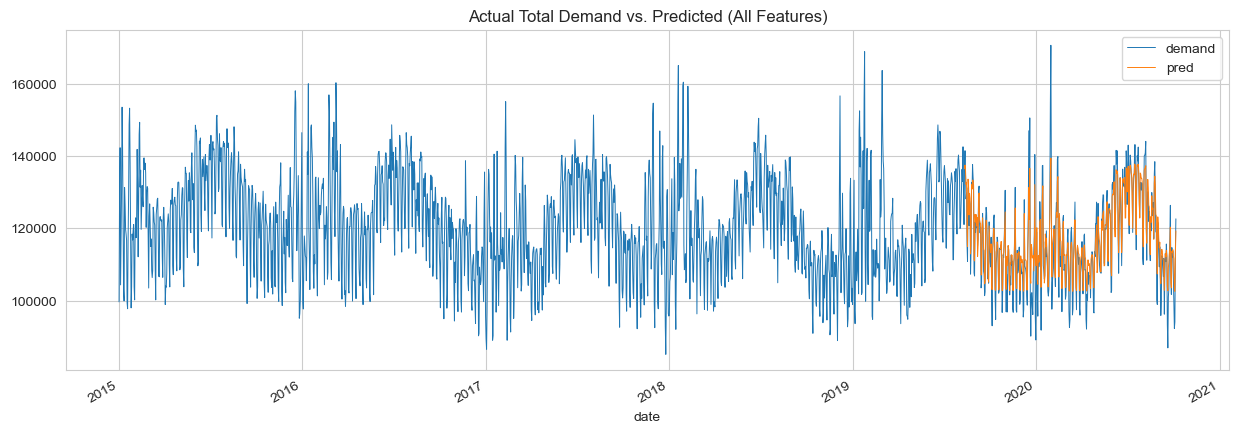

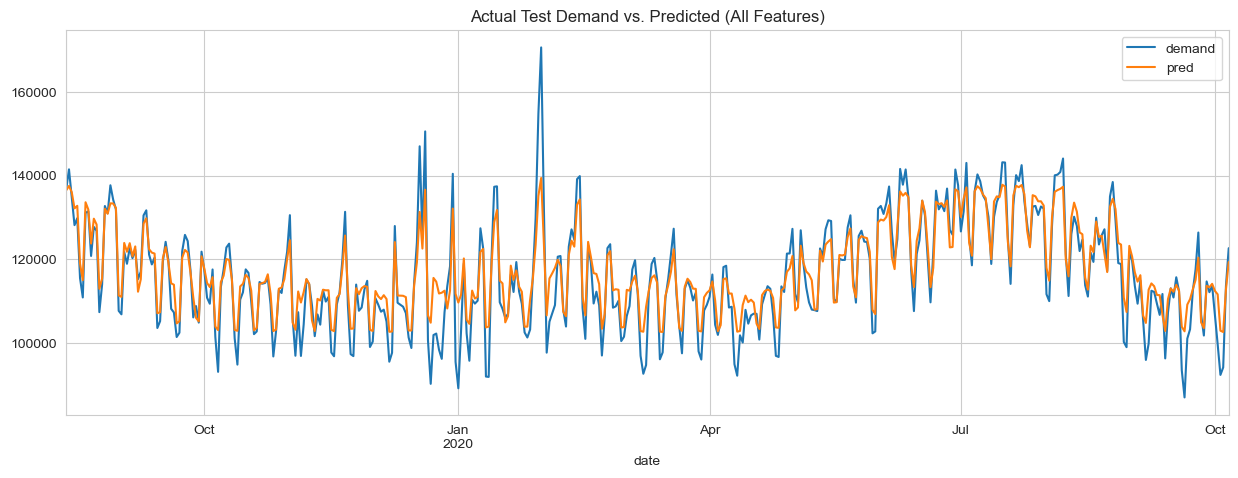

In [32]:
# Plotting prediction vs actual
df_eval = df_test.copy()
df_eval['pred'] = y_pred
df_all = pd.concat([df_eval, df_train], sort=False)
_ = df_all[['demand','pred']].plot(figsize=(15, 5), lw=0.7, title='Actual Total Demand vs. Predicted (All Features)')

# Closer Look
_ = df_eval[['demand', 'pred']].plot(figsize=(15, 5), lw=1.5, title='Actual Test Demand vs. Predicted (All Features)')

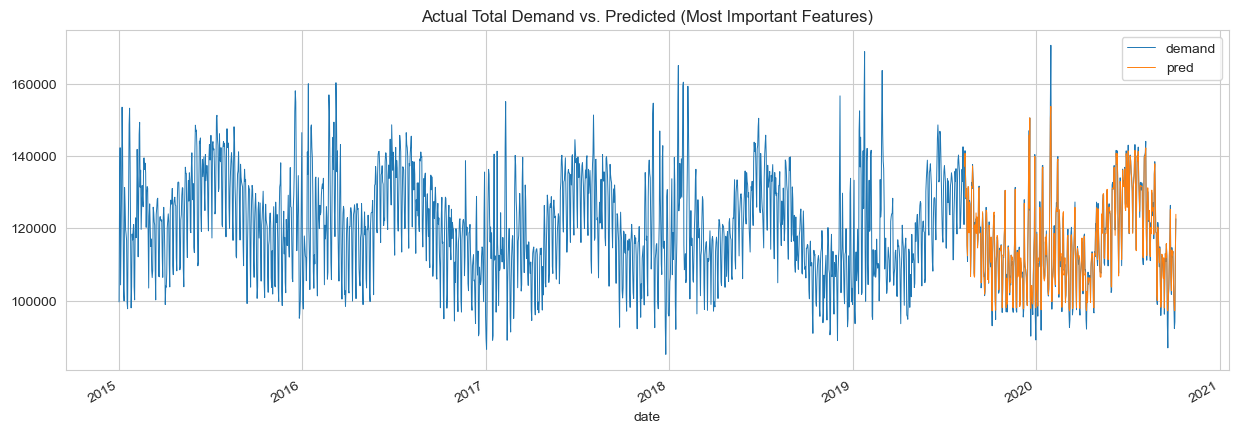

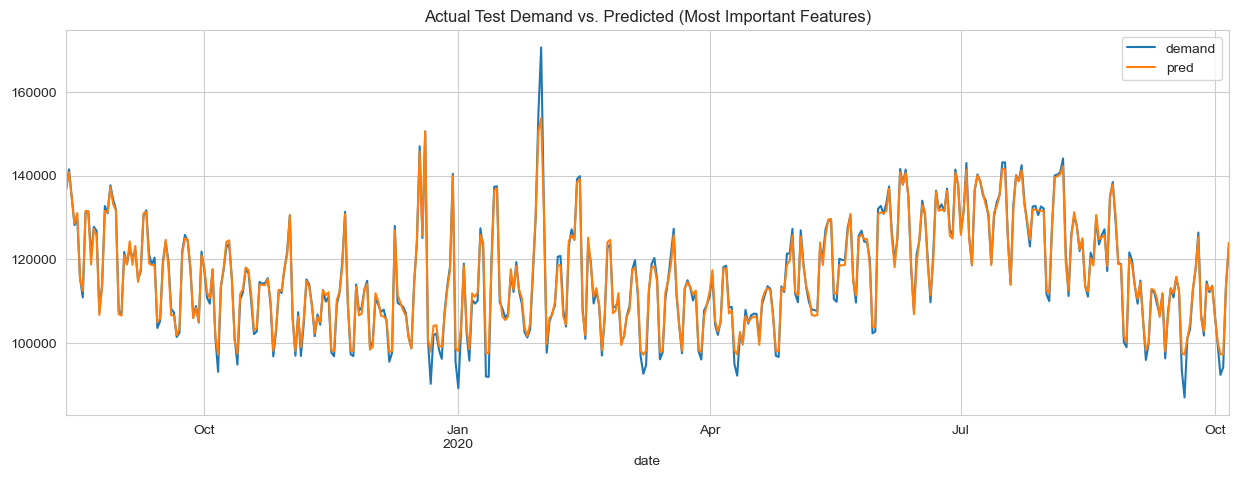

In [33]:
# Plotting prediction vs actual
df_eval = df_test.copy()
df_eval['pred'] = y_important_pred
df_all = pd.concat([df_eval, df_train], sort=False)
_ = df_all[['demand','pred']].plot(figsize=(15, 5), lw=0.7, title='Actual Total Demand vs. Predicted (Most Important Features)')

# Closer Look
_ = df_eval[['demand', 'pred']].plot(figsize=(15, 5), lw=1.5, title='Actual Test Demand vs. Predicted (Most Important Features)')

## Covid-19 Impact
In our original Train-Test sets, we split the data into 60:40 ratio. As a result, we were not able to account for training pre and post covid features effectively, since our data set dates only up until October 2020. Since the pre_covid feature (boolean) is 0 for all data before January 2020, our trained model could have not accounted for the possible effect of COVID-19 in electricity demand past the aforementioned date. Therefore, in order to allow our model to account for the impact of COVID-19 better, we will re-split our dataset to include some post-COVID dates in the train set. Since we need to preserve the 60:40 train-test ratio. 

### Quick Math for Deciding New Data Split
- Note that in our total data set, post-covid dates (i.e., from 01 Jan 2020) onwards are up to 06 Oct 2020. Let's say we want our new test set to include 70% of the total 279 days between this time period; therefore, we will need to have 196 days. 
- 195 days before 06 Oct 2020 is 25 March 2020.
- We also want to preserve our 60:40 ratio for our total train-test data sets, so our train set should be 1.5 times the total number of data of our test (195 * 1.5 = about 293 days)
- Thus, we will include only 293 days before 25 March 2020, which would be data from 06 June 2019. 

In [34]:
df_copy = df.loc['2019-06-06': ]
df_copy

,demand,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,month,season,day_of_week,...,rainfall_7_mean,rainfall_14_mean,rainfall_28_mean,rainfall_7_std,rainfall_14_std,rainfall_28_std,rainfall_7_min,rainfall_7_max,rainfall_14_max,rainfall_28_max
date,,,,,,,,,,,,,,,,,,,,,
2019-06-06,134971.775,10.2,14.8,7.9,0.0,1,0,6,3,4,...,3.200000,3.285714,2.228571,5.529316,4.406788,3.771124,0.0,15.4,15.4,15.4
2019-06-07,132003.440,11.7,16.6,8.0,0.0,1,0,6,3,5,...,3.000000,3.285714,1.971429,5.629683,4.406788,3.663520,0.0,15.4,15.4,15.4
2019-06-08,117243.630,6.7,18.7,9.3,0.0,1,0,6,3,6,...,2.657143,3.171429,1.678571,5.744231,4.474101,3.469802,0.0,15.4,15.4,15.4
2019-06-09,110669.420,7.8,18.0,8.0,0.0,1,0,6,3,7,...,2.657143,2.700000,1.678571,5.744231,4.432572,3.469802,0.0,15.4,15.4,15.4
2019-06-10,108133.030,12.0,19.2,7.6,3.0,1,1,6,3,1,...,0.885714,2.328571,1.785714,1.513747,4.144770,3.462360,0.0,3.2,15.4,15.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02,99585.835,12.8,26.0,22.0,0.0,0,0,10,4,5,...,2.114286,1.414286,1.264286,3.407555,2.569004,2.805842,0.0,9.4,9.4,11.8
2020-10-03,92277.025,17.4,29.4,19.8,0.0,0,0,10,4,6,...,0.771429,1.414286,1.257143,1.185628,2.569004,2.808905,0.0,3.0,9.4,11.8
2020-10-04,94081.565,13.5,29.5,8.4,0.0,0,0,10,4,7,...,0.342857,1.414286,1.250000,0.680336,2.569004,2.811945,0.0,1.8,9.4,11.8


In [35]:
_60percent = int(len(df_copy) * 0.6)

df_covid_train = df_copy[:_60percent]
df_covid_test = df_copy[_60percent:]

X_covid_train, y_covid_train = (df_covid_train, df_covid_train.demand)
X_covid_test, y_covid_test = (df_covid_test, df_covid_test.demand)

print('Train: ', X_covid_train.shape)
print('Test: ', X_covid_test.shape)

Train:  (293, 55)
Test:  (196, 55)


In [36]:
# COVID test df starts from 25 March 2020
df_covid_test.head()

,demand,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,month,season,day_of_week,...,rainfall_7_mean,rainfall_14_mean,rainfall_28_mean,rainfall_7_std,rainfall_14_std,rainfall_28_std,rainfall_7_min,rainfall_7_max,rainfall_14_max,rainfall_28_max
date,,,,,,,,,,,,,,,,,,,,,
2020-03-25,113147.815,10.8,17.5,7.6,0.0,0,0,3,2,3,...,0.057143,0.071429,2.357143,0.151186,0.185757,10.335463,0.0,0.4,0.6,54.6
2020-03-26,110088.010,13.7,19.8,15.5,0.0,0,0,3,2,4,...,0.057143,0.071429,2.350000,0.151186,0.185757,10.337078,0.0,0.4,0.6,54.6
2020-03-27,111958.245,13.6,27.6,17.8,0.0,0,0,3,2,5,...,0.057143,0.071429,2.350000,0.151186,0.185757,10.337078,0.0,0.4,0.6,54.6
2020-03-28,97923.715,14.8,27.5,16.9,0.0,0,0,3,2,6,...,0.057143,0.028571,2.350000,0.151186,0.106904,10.337078,0.0,0.4,0.4,54.6
2020-03-29,95953.205,16.5,26.4,9.5,0.0,0,0,3,2,7,...,0.057143,0.028571,2.350000,0.151186,0.106904,10.337078,0.0,0.4,0.4,54.6


### Compare ALL vs SELECTED Features again new COVID sets

In [37]:
# Build new RFR for covid set with ALL features
rfr_covid_all = rscv_results.best_estimator_
rfr_covid_all.fit(X_covid_train, y_covid_train)

# Apply The Full Featured Classifier To The Test Data
y_covid_pred = rfr_covid_all.predict(X_covid_test)

In [38]:
# Print Error Metrics for Original Set 
print('------------------------------------------------')
print('Error Metrics\n')
# Average actual demand in test set
actual_average = y_test.mean()
print('* Actual Average Demand: '+ str(np.round(actual_average, 2)))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_covid_pred, y_covid_test)
print('* Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_covid_pred, y_covid_test)
print('* Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_covid_pred, y_covid_test)
print('* Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

print('------------------------------------------------')

------------------------------------------------
Error Metrics

* Actual Average Demand: 115981.93
* Mean Absolute Error (MAE): 3810.86
* Mean Squared Error (MSE): 24470543.34
* Median Absolute Percentage Error (MAPE): 3.24 %
------------------------------------------------


In [39]:
# Generate df with only columns of important features for COVID-19 datasets
X_covid_important_train = rfe.transform(X_covid_train)
X_covid_important_test = rfe.transform(X_covid_test)

print('Train: ', X_covid_important_train.shape)
print('Test: ', X_covid_important_test.shape)

Train:  (293, 13)
Test:  (196, 13)


In [46]:
# Build new RF Regressor for COVID sets
rfr_covid_important = rscv_results.best_estimator_  # Same parameters as original RFR
rfr_covid_important.fit(X_covid_important_train, y_covid_train)

# Apply The Full Featured Classifier To The Test Data
y_covid_important_pred = rfr_covid.predict(X_covid_important_test)

In [47]:
# Print Error Metrics for New COVID set
print('--------------------------------------------------')
print('Error Metrics\n')
# Average actual demand in test set
actual_average = y_covid_test.mean()
print('* Actual Average Demand: '+ str(np.round(actual_average, 2)))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_covid_important_pred, y_covid_test)
print('* Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_covid_important_pred, y_covid_test)
print('* Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_covid_important_pred, y_covid_test)
print('* Median Absolute Percentage Error (MAPE): ' + str(np.round(MAPE*100, 2)) + ' %')

print('--------------------------------------------------')

--------------------------------------------------
Error Metrics

* Actual Average Demand: 119021.09
* Mean Absolute Error (MAE): 832.59
* Mean Squared Error (MSE): 1452542.58
* Median Absolute Percentage Error (MAPE): 0.73 %
--------------------------------------------------


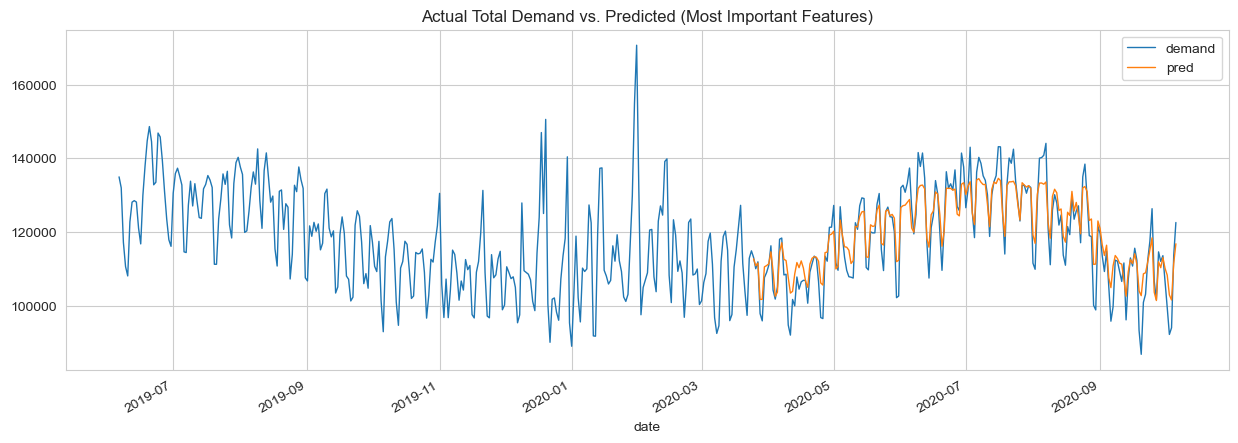

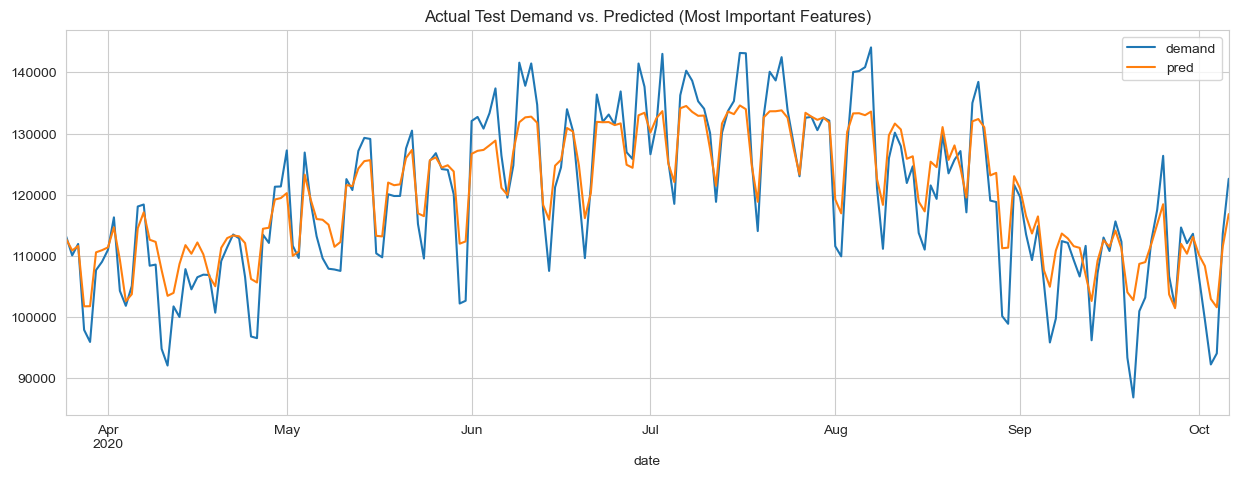

In [48]:
# Plotting prediction vs actual
df_covid_eval = df_covid_test.copy()
df_covid_eval['pred'] = y_covid_pred
df_covid_all = pd.concat([df_covid_eval, df_covid_train], sort=False)
_ = df_covid_all[['demand','pred']].plot(figsize=(15, 5), lw=1, title='Actual Total Demand vs. Predicted (Most Important Features)')

# Closer Look
_ = df_covid_eval[['demand', 'pred']].plot(figsize=(15, 5), lw=1.5, title='Actual Test Demand vs. Predicted (Most Important Features)')

As we can see here, our accuracy actually improved when accommodating more pre_covid data into our new train sets--both the ones where all features were selected and where only the top 25% were selected.

# Save model

In [51]:
pickle.dump(rfr_important, open('RF-RFE.pkl', 'wb'))

To load model in the future, please run the following code:

pickled_model = pickle.load(open('RF-RFE.pkl', 'rb'))

pickled_model.predict(X_test)